# Tracking Demonstration

This notebook applies vehicles [**tracking**](#Apply-Tracking) for **a single 8-minute-video** using [pytorch_objectdetecttrack](https://github.com/cfotache/pytorch_objectdetecttrack) with a few minor modifications (e.g. accelerated renewal of tracking after a frame with no detection), shows various [**properties of the trackings**](#Explanatory-Descriptive-Analysis), studies some [**anomalies**](#Invalid-Trackings-Study) in the trackings (most of them relate to the detection & tracking algorithms rather than behavior of the vehicles), and studies the [**driving speed**](#Driving-Speed-Analysis) of the cars along the video.

- [**Tracking**](#Apply-Tracking)
- [**Explanatory Descriptive Analysis**](#Explanatory-Descriptive-Analysis)
- [**Anomalies Study**](#Invalid-Trackings-Study)
- [**Driving Speed Analysis**](#Driving-Speed-Analysis)
- [**Summary**](#Summary)

## Configuration

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter, OrderedDict
import cv2
from PIL import Image
from IPython.display import clear_output

In [65]:
import track_tools as tt
clear_output()

In [4]:
mpl.rcParams.update({'font.size': 14})
cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

In [5]:
MODE = 'load' # 'load' / 'save' / None
OUT_PATH = Path('tracking_demo_data')
OUT_FILE = OUT_PATH/'20190612_175832.slow.pkl' # '20190612_175832.slow.pkl' / 'tmp.pkl'
MAX_FRAMES = np.Inf # np.Inf
AREA = (0, 650, -350, -50)
DISPLAY = True
FPS = 30/8

DATA = Path(r'D:\Media\Videos\Ayalon')
# videopath = str(DATA/'20190622_124116.mp4') # bad detection
# videopath = str(DATA/'20190703_163050_slipping_protest.2.mp4') # fast
videopath = str(DATA/'20190612_175832.mp4') # slow

## Apply Tracking

In [8]:
if MODE == 'load':
    
    with open(OUT_FILE,'rb') as f:
        dct = pkl.load(f)
    X = dct['X']
    Y = dct['Y']
    S = dct['S']
    C = dct['C']
    W = dct['W'] if 'W' in dct else AREA[1]-AREA[0]
    H = dct['H'] if 'H' in dct else AREA[3]-AREA[2]
    
else:

    %pylab inline
    X,Y,S,C,other_objs,W,H = tt.analyze_video(videopath, area=AREA, MAX_FRAMES=MAX_FRAMES, DISPLAY=True)

In [9]:
df, slope = tt.summarize_video(X,Y,S,C,W,H,FPS)
df.head()

d:\code\python\Ayalon\objectdetecttrack\track_tools.py:449: RuntimeWarning: invalid value encountered in longlong_scalars
  for car in X.columns]


Data frame shape:
(1410, 27)


,class,n_shots,consistent_class,consistent_xy_nas,continuous_track,avg_size,max_size,valid_size,neg_x_motion,neg_y_motion,...,dt,dx,dy,x_path_rel,y_path_rel,long_path,v,abs_v,road_perpendicularity,perpendicular_range
12,truck,8,True,True,False,102.162959,108.226614,True,0.0,0.000000,...,2.133333,108.5,27.0,0.166923,0.090000,False,52.410464,52.604975,36.074527,8.544228
11,car,40,True,True,True,58.064291,61.911227,True,0.0,0.019417,...,10.400000,337.0,99.0,0.518462,0.330000,True,33.773140,34.461132,27.207700,9.373706
10,car,3,True,True,True,65.790297,67.601775,True,0.0,0.000000,...,0.533333,25.0,10.0,0.038462,0.033333,False,50.485920,50.831730,68.545011,2.631716
9,car,11,True,True,False,55.986974,57.801384,True,0.0,0.000000,...,2.933333,20.5,9.0,0.031538,0.030000,False,7.632482,8.105283,-8.663773,3.284250
8,car,1,True,True,True,62.649820,62.649820,True,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,False,NaN,NaN,56.154629,0.000000


In [10]:
if MODE == 'save':
    with open(OUT_FILE,'wb') as f:
        pkl.dump({'X':X, 'Y':Y, 'S':S, 'C':C, 'W':W, 'H':H, 'others':other_objs, 'df':df}, f)

In [11]:
gc.collect()

105

## Explanatory Descriptive Analysis

In [20]:
mpl.rcParams.update({'font.size': 13})

#### Show all trackings

Wall time: 4.58 s


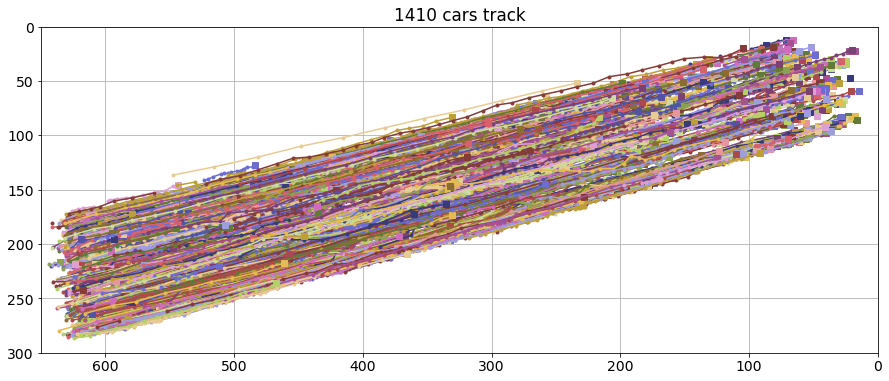

In [13]:
%%time

plt.figure(figsize=(15,6))
plt.title(f'{X.shape[1]:d} cars track')
tt.set_track_figure(W,H)

for car in X.columns:
    tt.plot_track(X,Y,car)

#### Show distributions of data columns

In [14]:
variables_groups_to_compare = (
    ('consistent_class','consistent_xy_nas','valid_size','valid_x_dir','valid_y_dir'),
    ('continuous_track','long_path'),
    ('min_x','max_x'),
    ('min_y','max_y'),
    ('avg_size','max_size'),
    ('v','abs_v'),
)

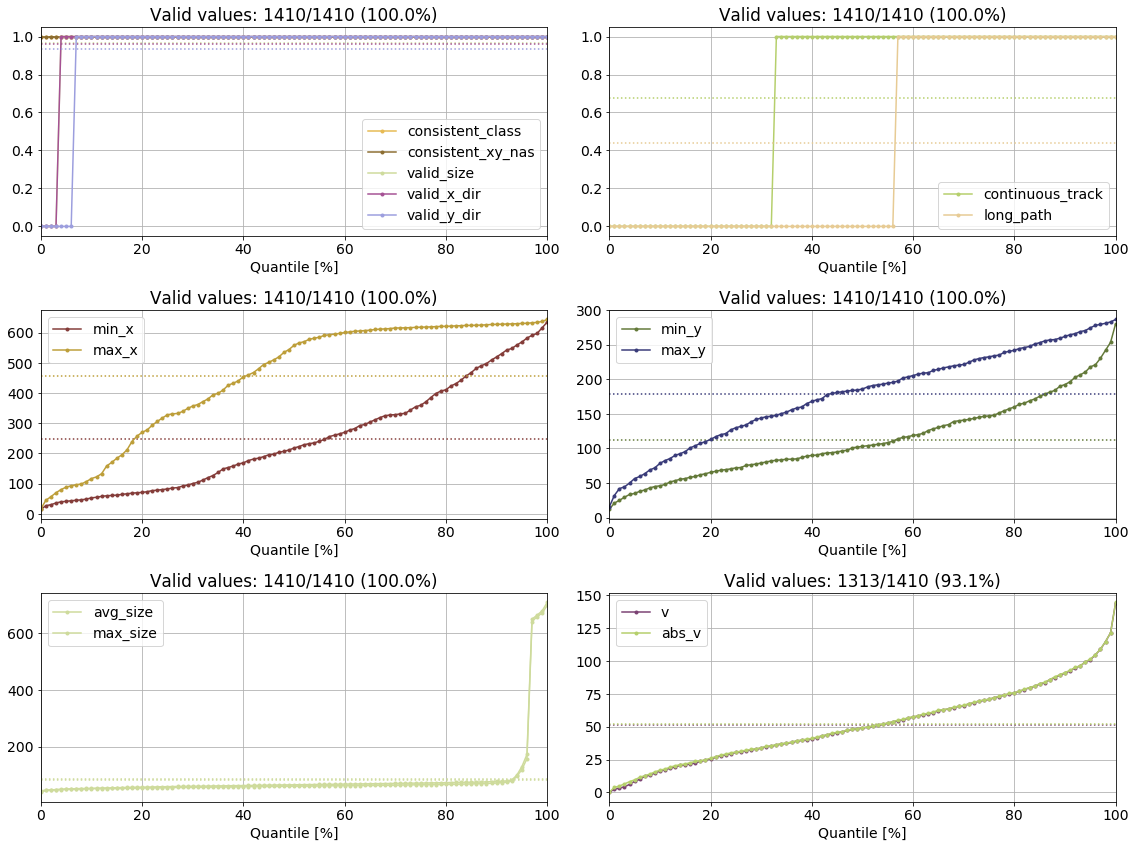

In [15]:
n_rows = int(np.ceil(5/2))
_, axs = plt.subplots(n_rows, 2, figsize=(16,n_rows*4))

for i, cols in enumerate(variables_groups_to_compare):
    ax = plt.subplot(n_rows, 2, i+1)
    tt.qplots(df.loc[:,cols])

plt.tight_layout()

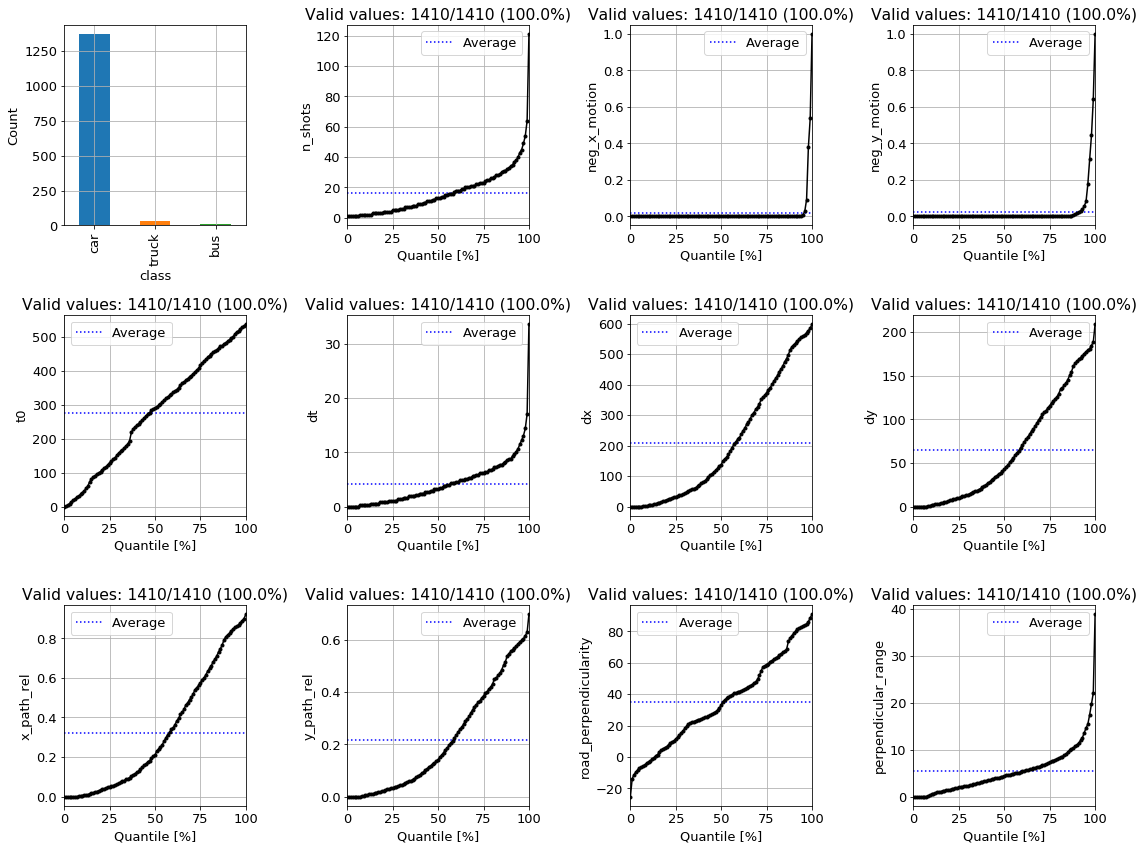

In [21]:
cols = [col for col in df.columns if not col in [c for grp in variables_groups_to_compare for c in grp]]
n_rows = int(np.ceil(len(cols)/4))
_, axs = plt.subplots(n_rows, 4, figsize=(16,n_rows*4))

for i,c in enumerate(cols):
    ax = plt.subplot(n_rows, 4, i+1)
    if type(df[c][0]) is str:
        df[c].value_counts().plot('bar')
        ax.set_xlabel(c)
        ax.set_ylabel('Count')
        ax.grid()
    else:
        tt.qplot(df[c], ax=ax, ylab=c, logscale=False)

plt.tight_layout()

#### Show relations between a few pairs of columns

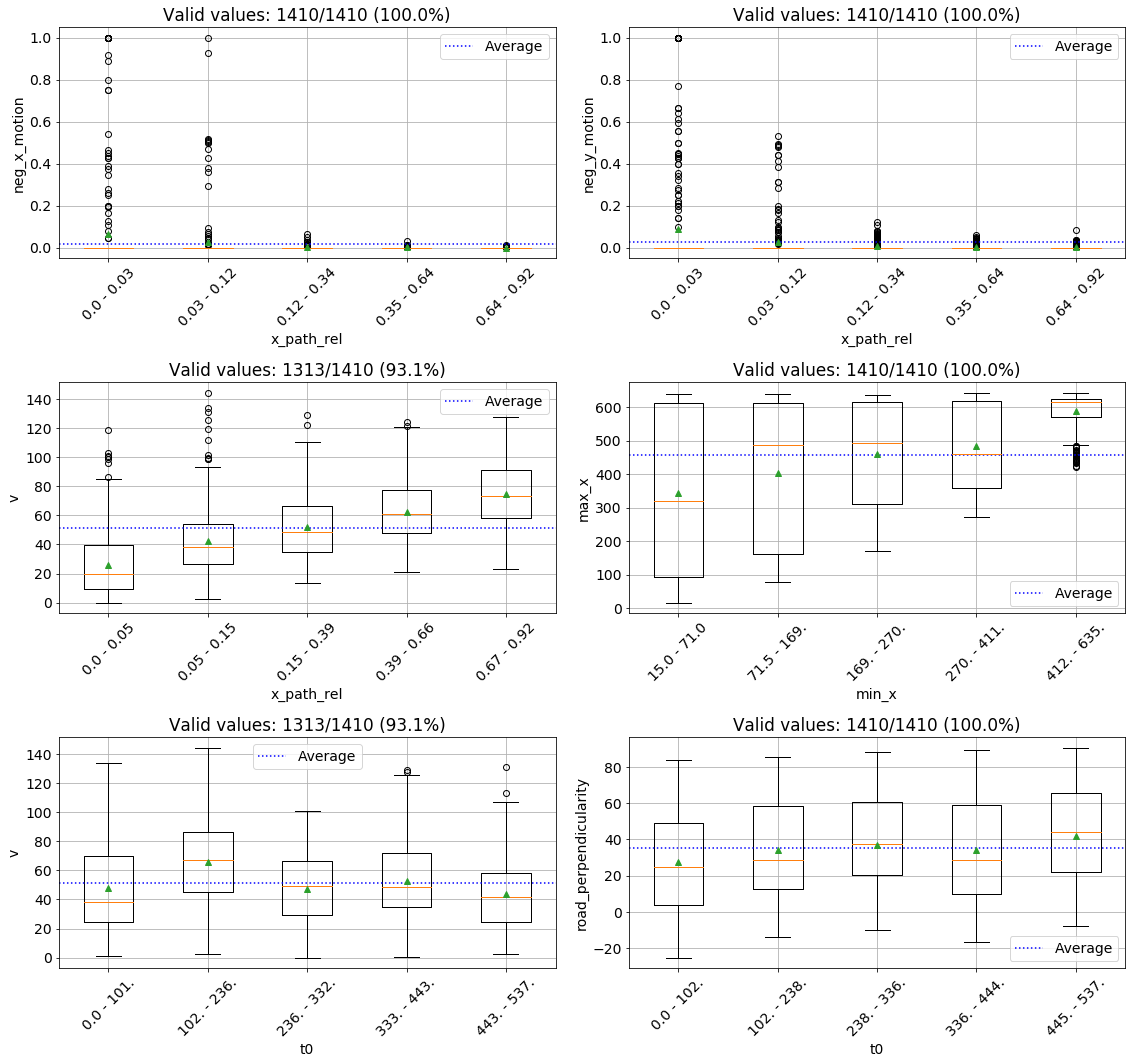

In [17]:
pairs = (
    ('x_path_rel','neg_x_motion'),
    ('x_path_rel','neg_y_motion'),
    ('x_path_rel','v'),
    ('min_x','max_x'),
    ('t0','v'),
    ('t0','road_perpendicularity'),
)

n_rows = int(np.ceil(len(pairs)/2))
_, axs = plt.subplots(n_rows, 2, figsize=(16,n_rows*5))

for i,(c1,c2) in enumerate(pairs):
    ax = plt.subplot(n_rows, 2, i+1)
    tt.boxplot_per_bucket(df[c1], df[c2], ax=ax, xlab=c1, ylab=c2, logscale=False)

plt.tight_layout()

## Invalid Trackings Study

Valid fields:  consistent_class, consistent_xy_nas

valid_x_dir overlaps (all=53):
{'valid_y_dir': 43, 'valid_size': 33, 'long_path': 53, 'continuous_track': 24}

valid_y_dir overlaps (all=96):
{'valid_x_dir': 43, 'valid_size': 33, 'long_path': 88, 'continuous_track': 49}

valid_size overlaps (all=48):
{'valid_x_dir': 33, 'valid_y_dir': 33, 'long_path': 48, 'continuous_track': 17}

long_path overlaps (all=790):
{'valid_x_dir': 53, 'valid_y_dir': 88, 'valid_size': 48, 'continuous_track': 208}

continuous_track overlaps (all=460):
{'valid_x_dir': 24, 'valid_y_dir': 49, 'valid_size': 17, 'long_path': 208}


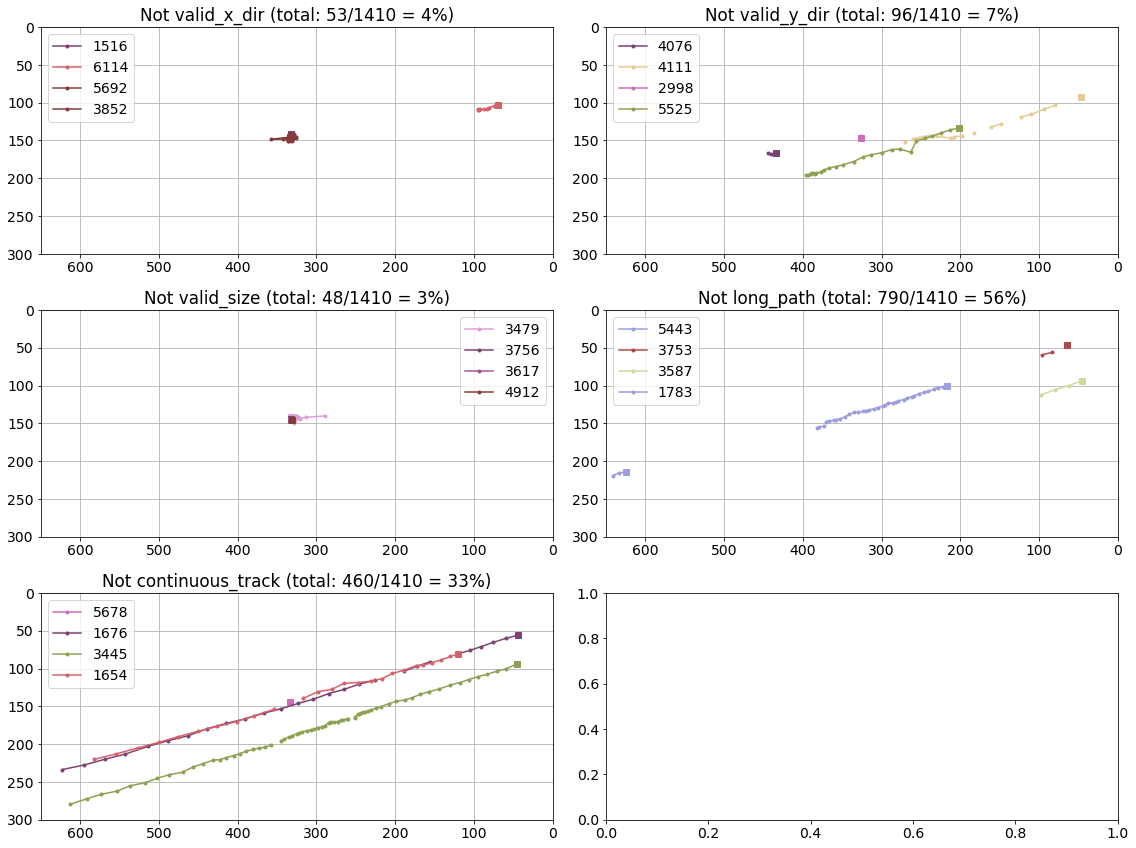

In [18]:
validations = ('consistent_class','consistent_xy_nas','valid_x_dir','valid_y_dir','valid_size','long_path','continuous_track')
n_samples = 4

all_valid = [val for val in validations if df[val].all()]
print('Valid fields: ', ', '.join(all_valid))

validations = [val for val in validations if val not in all_valid]
n_rows = int(np.ceil(len(validations)/2))
_, axs = plt.subplots(n_rows, 2, figsize=(16,n_rows*4))

for i,val in enumerate(validations):
    ax = plt.subplot(n_rows, 2, i+1)
    tt.set_track_figure(W,H,ax)
    
    cars = df.index[np.logical_not(df[val])]
    n_bad = len(cars)
    if n_samples < len(cars):
        cars = np.random.choice(cars, n_samples, replace=False)
    
    for car in cars:
        tt.plot_track(X,Y,car,ax)
    ax.set_title(f'Not {val:s} (total: {n_bad:d}/{df.shape[0]:d} = {100*n_bad/df.shape[0]:.0f}%)')
    ax.legend()
    
    print(f'\n{val:s} overlaps (all={np.sum(np.logical_not(df[val])):d}):')
    print({val2: np.sum(np.logical_not(df.loc[np.logical_not(df[val]),val2])) for val2 in validations if val2!=val})

plt.tight_layout()

"Large" cars:

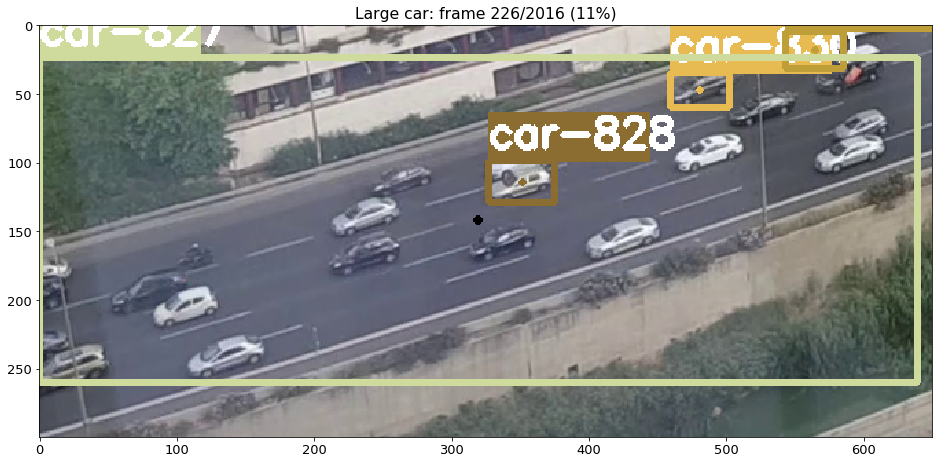

In [38]:
tt.record_frame(videopath, X, Y, '511', frm=1, self_track=3,
                display=True, boxes=True, to_save=OUT_PATH/'large_car', TITLE='"Large car"')

Negative motion along y-axis:

In [24]:
tt.record_video(videopath, X, Y, '79', self_track=8, display=False, to_save=OUT_PATH/'neg_y')
clear_output()

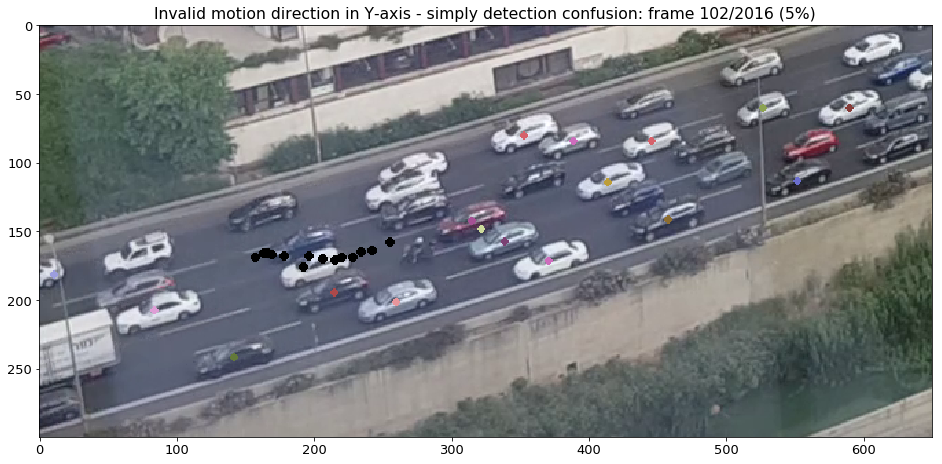

In [39]:
tt.record_frame(videopath, X, Y, '79', frm=52+50, self_track=8, display=True, to_save=OUT_PATH/'neg_y',
                TITLE='Invalid motion direction in Y-axis - simply detection confusion')

Motion perpendicular to the road:

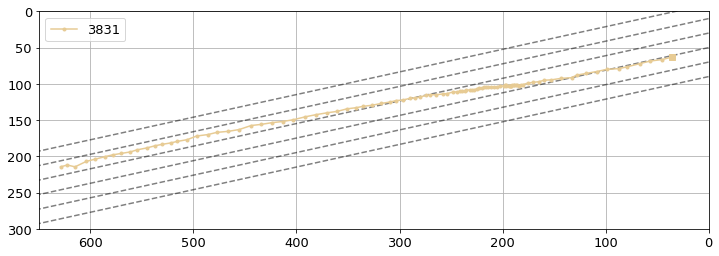

In [26]:
plt.figure(figsize=(12,4))

for i in range(-10,91,20):
    plt.plot(np.linspace(0, W, 100), slope*np.linspace(0, W, 100) + i, 'k--', alpha=0.5)

tt.set_track_figure(W,H)
car = np.random.choice(df.index[df.perpendicular_range>30])
tt.plot_track(X,Y,car)
plt.legend()

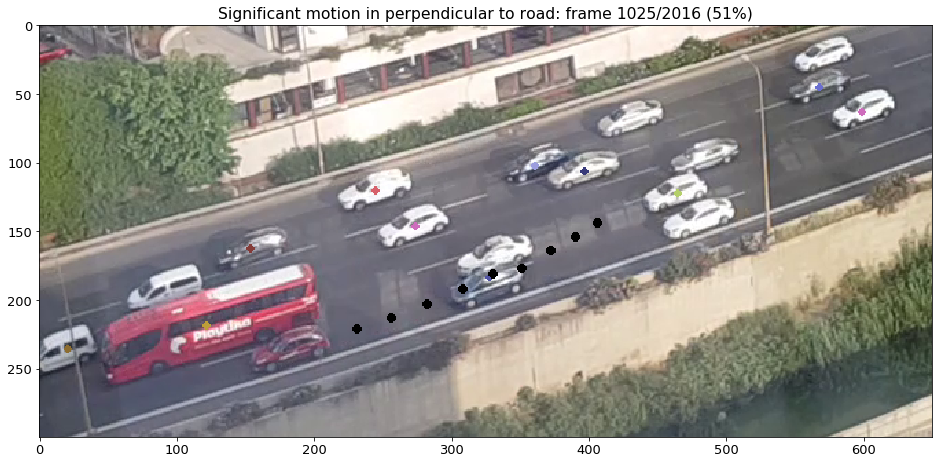

In [27]:
tt.record_frame(videopath, X, Y, '3647', frm=14, self_track=4, display=False, to_save=OUT_PATH/'perp1a')
tt.record_frame(videopath, X, Y, '3647', frm=17, self_track=4, display=True, to_save=OUT_PATH/'perp1b',
               TITLE='Motion perpendicular to road - simply detection confusion')

In [28]:
tt.record_video(videopath, X, Y, '3647', self_track=4, display=False, to_save=OUT_PATH/'perp2')
clear_output()

## Driving Speed Analysis

Valid tracks:	612/1410 (43%)


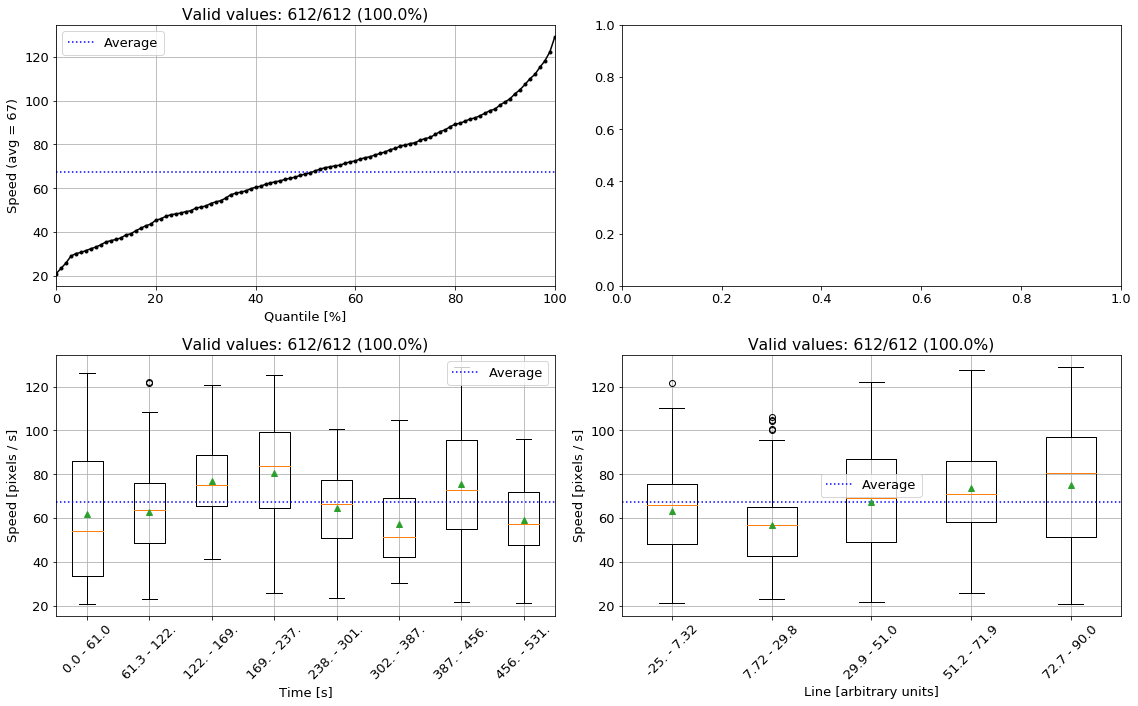

In [29]:
ids = df.loc[:,['consistent_class','consistent_xy_nas','valid_x_dir','valid_y_dir',
                'valid_size','long_path']].all(axis=1)

print(f'Valid tracks:\t{ids.sum()}/{len(ids)} ({100*ids.mean():.0f}%)')

_, axs = plt.subplots(2,2, figsize=(16,10))
tt.qplot(df.v[ids], ylab=f'Speed (avg = {df.v[ids].mean():.0f})', ax=axs[0,0])
tt.boxplot_per_bucket(df.t0[ids], df.v[ids], n_buckets=8, xlab='Time [s]', ylab='Speed [pixels / s]', ax=axs[1,0])
tt.boxplot_per_bucket(df.road_perpendicularity[ids], df.v[ids],
                      xlab='Line [arbitrary units]', ylab='Speed [pixels / s]', ax=axs[1,1])
plt.tight_layout()

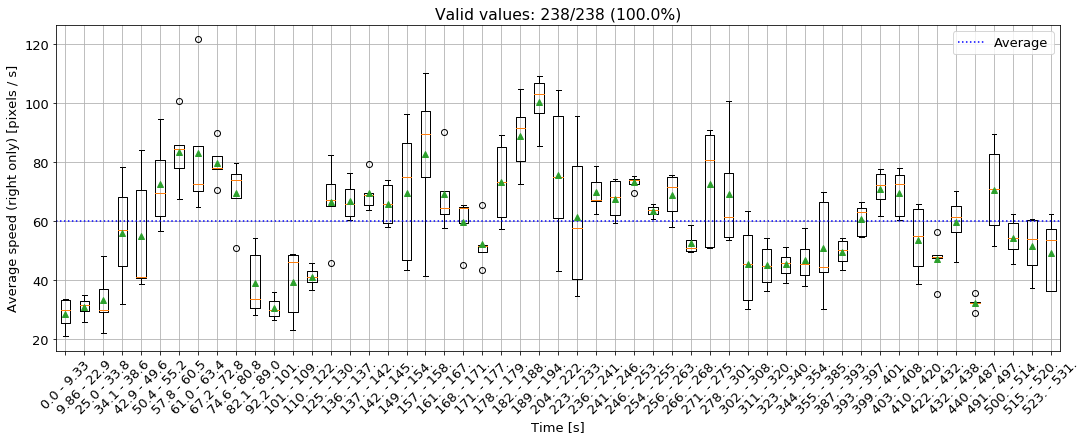

In [30]:
ids = df.loc[:,['consistent_class','consistent_xy_nas','valid_x_dir','valid_y_dir',
                'valid_size','long_path']].all(axis=1)
ids = np.logical_and(ids, df.road_perpendicularity<29)

plt.figure(figsize=(18,6))
tt.boxplot_per_bucket(df.t0[ids], df.v[ids], n_buckets=530//10, xlab='Time [s]', ylab='Average speed (right only) [pixels / s]')

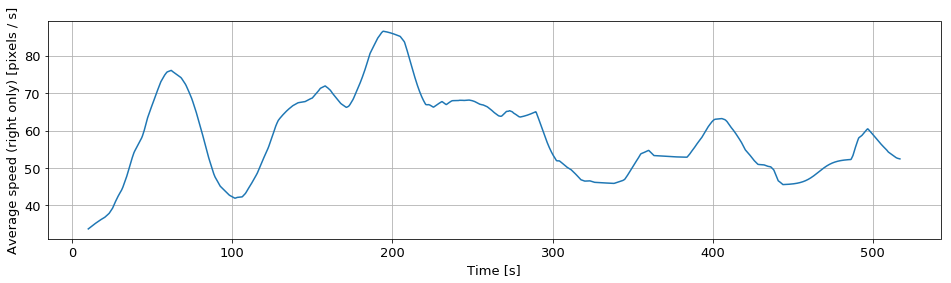

In [31]:
times = list(np.arange(10, df.t0.max()-20, 1/FPS))
decay = 10 # 1/e factor every "decay" seconds
ws = [np.exp(-np.abs(df[ids].t0-t)/decay) for t in times]
rolling_speed = [np.sum(w*df[ids].v)/np.sum(w) for w in ws]

_, axs = plt.subplots(1,1,figsize=(16,4))
ax = axs
ax.plot(times, rolling_speed)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Average speed (right only) [pixels / s]')
ax.grid()

In [32]:
ids = df.loc[:,['consistent_class','consistent_xy_nas','valid_x_dir','valid_y_dir',
                'valid_size','long_path']].all(axis=1)

fastest = df[ids].v.argmax()
slowest = df[ids].v.argmin()

tt.record_video(videopath, X, Y, fastest, display=False, to_save=OUT_PATH/'fastest')
tt.record_video(videopath, X, Y, slowest, display=False, to_save=OUT_PATH/'slowest')
clear_output()

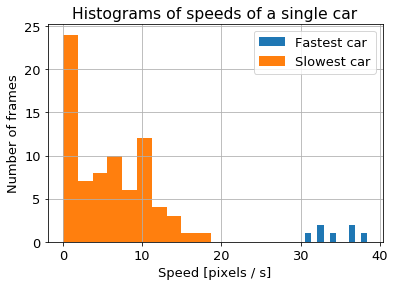

In [64]:
car = fastest
fast_speeds = np.power(np.power(X[car][X[car].notnull()].diff()[1:],2) + np.power(Y[car][Y[car].notnull()].diff()[1:],2), 0.5) /\
              np.diff(np.array(X.index[X[car].notnull()]))

car = slowest
slow_speeds = np.power(np.power(X[car][X[car].notnull()].diff()[1:],2) + np.power(Y[car][Y[car].notnull()].diff()[1:],2), 0.5) /\
              np.diff(np.array(X.index[X[car].notnull()]))

plt.hist(list(fast_speeds), label='Fastest car')
plt.hist(list(slow_speeds), label='Slowest car')
plt.xlabel('Speed [pixels / s]')
plt.ylabel('Number of frames')
plt.title('Histograms of speeds of a single car')
plt.grid()
plt.legend()
clear_output()

## Summary

#### Detection:

- It looks like the **detection rate** of the vehicles does not reach 50%. It is unknown whether there is relevant filter bias in the detected vehicles (e.g. it might be that crowded vehicles are not detected, leading to filtering of slower drivings from the data.

#### Anomalous trackings:

- **Way-too-large vehicles** should be just filtered out.
- **Invalid motion direction** is usually either for small part of the path (< 4%) or associated with a short path (hence filtered anyway).
- Whenever **a sequence of detections is interrupted by mis-detection** even in a single frame, [SORT](https://github.com/abewley/sort) ignores it until it has a new sequence of several detections, causing unnecessarily-large gaps in the tracking data. The code of SORT was therefore modified to output re-detected objects immediately.
- **Motions perpendicular to the direction of road** (as well as "negative" motions in Y-axis) are typically caused by tracking-confusions (associate different vehicles with the same object ID), which currently seem to occur in around 2% of the tracks and may or may not affect the speed estimation significantly.
   - Note: the fact that the confusions are noticable means that the resolution also permits detection of path-transitions of vehicles (if they can be distinguished from tracking-confusions).

#### Speed analysis:

- Speed varies between **lines**. In particular, the rightest line is very slow.
- Speed varies a lot over **time**, without any clear periodicity.

**TODO**
- improve tracking (see readme): see what's the noise of ratio(box) (should be in angles rather than ratio); see what's the noise of the location in perpendicular direction.
   - update conclusions.
- run over all videos (not in notebook).
- improve detection.